In [27]:
import pandas as pd

df = pd.read_csv("ann_sample.csv")
print(df)

   1   70  120
0  2   60  420
1  3  124  110
2  4  186  330
3  5   78   90


In [28]:
x = df.iloc[:, 1:3:]
y = df.iloc[:, 3:]
print(x)
print(y)

    70  120
0   60  420
1  124  110
2  186  330
3   78   90
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3]


In [29]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit(y)
print(ohe.categories_)
y = ohe.transform(y)
print(y)

[]
[]


In [30]:
from sklearn.model_selection import train_test_split
import torch

x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True)

In [31]:
import torch.nn as nn


class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 8)
        self.act = nn.ReLU()
        self.output = nn.Linear(8, 7)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden): Linear(in_features=2, out_features=8, bias=True)
  (act): ReLU()
  (output): Linear(in_features=8, out_features=7, bias=True)
)

In [32]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
random.seed(10)

In [33]:
import torch
from torch import nn
import tqdm
import copy

n_epochs = 45
batch_size = 2
batches_per_epoch = len(x_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(x_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0:   0%|          | 0/1 [00:00<?, ?batch/s]


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

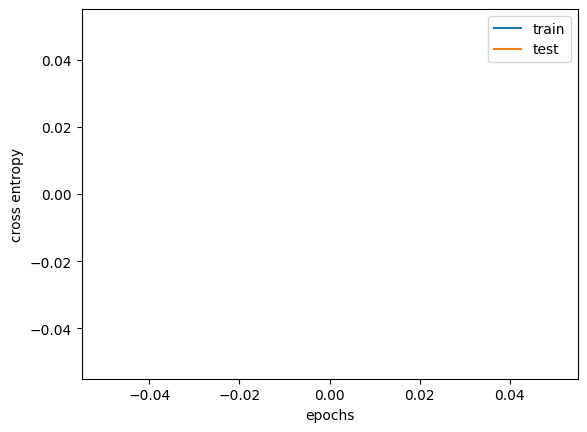

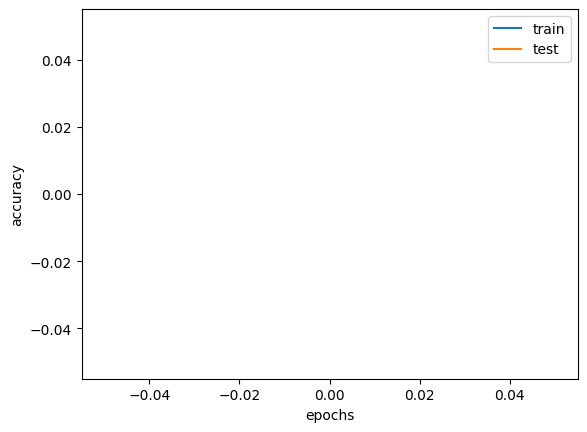

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[-0.0715, -0.3317],
                      [-0.1001, -0.1484],
                      [ 0.0547, -0.1324],
                      [-0.0265,  1.0004],
                      [-0.2890, -0.1506],
                      [-0.0367, -2.8165],
                      [-0.5688,  0.1416],
                      [-0.1868, -0.5335]])),
             ('hidden.bias',
              tensor([  0.7060,   0.4440,  -6.4244, -30.7195,  -0.4478,  11.7736,  -0.5143,
                        0.3496])),
             ('output.weight',
              tensor([[ 0.2536,  0.1316,  0.0457, -0.3158,  0.2910,  0.2955,  0.1517, -0.0448],
                      [-0.0460,  0.1455, -0.3590, -0.2549,  0.2641, -0.2293,  0.2295,  0.0612],
                      [ 0.2887,  0.1267, -0.1347, -0.0669,  0.1652, -0.9932,  0.0836,  0.1137],
                      [ 0.2909,  0.3312,  0.0525, -0.0729,  0.2418,  0.1263,  0.1381, -0.1694],
                      [-0.3358, -0.1288, -0.4989, -0.0709, 

In [ ]:
# import libraries
import numpy as np


# network structure, weights, biases and activation of output neurons of existing ANN
def load_model():
    network_structure = [2, 8, 7]  # input layer, hidden layer, output layer
    weights = np.array(
        [
            [-0.4871, 0.4588],
            [0.1166, -0.1489],
            [-0.3272, -0.2266],
            [-0.5175, -0.6446],
            [0.0034, -0.3747],
            [0.2433, -0.9956],
            [-0.5528, 0.1114],
            [-0.7009, -0.0797],
            [0.1875, -0.0693, 0.1593, 0.1602, -0.0583, 0.0691, 0.0145, -0.2651],
            [0.1423, 0.0313, -0.0958, -0.0754, 0.2851, -0.0180, 0.2254, -0.3393],
            [0.2080, 0.0757, -0.0151, -0.2200, -0.0530, -0.0331, 0.2056, 0.1037],
            [0.1781, 0.0196, 0.2189, 0.2274, -0.1738, 0.0183, -0.1070, 0.0005],
            [-0.1503, 0.1061, -0.2775, -0.2963, -0.0259, -0.1162, 0.2827, -0.1819],
            [0.2241, 0.1271, -0.0551, -0.0440, -0.2558, -0.0589, -0.1493, -0.2189],
            [-0.3357, 0.0331, 0.0676, 0.3495, 0.1933, -0.1002, -0.0398, 0.1658],
        ],
        dtype=object,
    )
    biases = np.array(
        [
            -0.6060,
            -0.9959,
            -0.5868,
            -0.2179,
            0.1709,
            -0.7707,
            -0.5986,
            0.0133,
            -1.2405,
            0.8796,
            0.5822,
            -1.4428,
            0.8834,
            -1.9192,
            1.4445,
        ]
    )
    classification_threshold = 0.5  # output activation needed to assign to class

    return network_structure, weights, biases, classification_threshold

model.state_dict()

In [ ]:
import numpy as np  


# Integrate and Fire Neuron Object
class IF_Neuron:
    def __init__(self, layer, weights, bias, steps, v_th):
        self.layer = layer  # Layer of Neuron
        self.weights = weights  # Weights
        self.bias = bias  # Bias

        # IF Properties
        self.steps = steps  # Number of steps for calculation
        self.v = np.empty([self.steps])  # Neuron Value
        self.v[0] = 0  # Set start Value
        self.spikes = np.empty([self.steps])  # Output spike train
        self.n_spikes = 0  # Number of spikes
        self.v_th = v_th  # Threshold

    def reset(self):  # Reset Neuron
        self.v = np.empty([self.steps])
        self.v[0] = 0
        self.spikes = np.empty([self.steps])
        self.n_spikes = 0

    def calculate(self, neuron_input):
        for i in range(self.steps):  # for every step
            if i > 0:  # not first element
                self.v[i] = self.v[i - 1]
            for j in range(len(neuron_input)):  # for every input channel
                if neuron_input[j][i]:  # if spike present
                    self.v[i] = self.v[i] + self.weights[j]
            self.v[i] = self.v[i] + self.bias
            if self.v[i] > self.v_th:  # if above threshold
                self.n_spikes += 1  # increase number of spikes
                self.spikes[i] = 1  # add spike to spike trace
                self.v[i] = self.v[i] - self.v_th  # difference reset
                # self.Vm[i] = self.bias            # hard reset
            else:  # add no spike to spike trace
                self.spikes[i] = 0

In [ ]:
def create_neurons(structure, weights, biases, steps, v_th, net_type):
    neuron_array = []  # array in which the neuron objects will be saved
    neuron_number = 0  # counter to initialize/create the neuron objects

    for layer in range(
        1, len(structure)
    ):  # for every layer (except layer 0 which is input)
        for neuron in range(structure[layer]):  # for number of neurons in layer
            # create SNN neurons
            neuron_array.append(
                IF_Neuron(
                    layer,
                    weights[neuron_number],
                    biases[neuron_number],
                    steps,
                    v_th[layer - 1],
                )
            )

    return neuron_array  # array of neuron objects

In [ ]:
def reset_neurons(neuron_array):
    for neuron in neuron_array:
        neuron.reset()

In [ ]:
def calculate_pixel(network_structure, neuron_array, input_elements, net_type):
    max_activation = [0] * len(network_structure)
    for layer in range(1, len(network_structure)):  # for layer
        if layer == 1:  # if input layer
            neuron_input_array = input_elements  # get img values as input
        else:  # otherwise, get outputs of previous layer
            neuron_input_array = []
            for neuron in neuron_array:
                if neuron.layer == layer - 1:
                    neuron_input_array.append(neuron.spikes)  # spikes output

        for neuron in neuron_array:  # get all neurons of current layer and calculate
            if neuron.layer == layer:
                neuron.calculate(neuron_input_array)

    return max_activation

In [ ]:
import random

steps = 5


def create_input_spike(input_array, steps):
    input_spike = np.zeros(steps)
    # rr_values_array=rr_values_array.astype(int)
    # for i, value in enumerate(rr_values_array):
    for l in range(steps):
        rnd = random.randrange(60, 120)
        # print(f"rnd:{rnd}")
        # print(f"input_array:{rr_values_array}")
        print(f"input_spike:{input_spike}")
        if rnd < input_array:
            input_spike[l] = 1

    return input_spike

In [ ]:
steps = 5


def create_input_spikes(input_array, steps):
    input_spikes = np.zeros(steps)
    for i in range(len(input_array)):
        for j in range(len(input_array[i])):
            if j == 0:
                pass_value1 = input_array[i][j]
                # pass_value1=pass_value1.astype(int)
                spikes1 = create_input_spike(pass_value1, steps)
                print(f"spikes1:{spikes1}")
            if j == 1:
                pass_value2 = input_array[i][j]
                # pass_value2=pass_value2.astype(int)
                spikes2 = create_input_spike(pass_value2, steps)
                print(f"spikes2:{spikes2}")
    return input_spikes

In [ ]:
def calculate_network(network_structure, neuron_array, input_array, steps, net_type):
    output_array = []
    max_activation = [0] * len(network_structure)
    max_activation[0] = 1
    number_of_total_spikes = 0

    for i, pixel in enumerate(input_array):  # for every pixel
        if (i + 1) / len(input_array) * 100 % 1 == 0:  # print status update
            print("\r", f"{int((i+1)/len(input_array)*100)}% done", end="")
            # if SNN
            reset_neurons(neuron_array)  # reset neurons
            input_spikes = create_input_spikes(pixel, steps)  # convert input to spikes
            calculate_pixel(network_structure, neuron_array, input_spikes, net_type)
        else:  # if ANN
            temp_max_act = calculate_pixel(
                network_structure, neuron_array, pixel, net_type
            )
            for j, element in enumerate(temp_max_act):
                max_activation[j] = max(max_activation[j], element)
        temp_out = []  # temporary array to store outputs
        for neuron in neuron_array:  # for every neuron
            number_of_total_spikes += neuron.n_spikes
            if neuron.layer == (len(network_structure) - 1):  # if output neur
                temp_out.append(
                    neuron.n_spikes
                )  # append number of spikes per output ne                     # append value of output neuron
        output_array.append(temp_out)  # append to output values
    print("\r", f"", end="")
    output_array = np.array(output_array)  # convert tu numpy array

    return output_array, max_activation

In [ ]:
# from prg
le1 = 5
for i in range(len(input_array)):
    spikes = np.vstack((spikes1, spikes2))
    print(f"spikes:{spikes}")
    for j in range(len(input_array[i])):
        if j == 0:
            pass_value1 = input_array[i][j]
            pass_value1 = pass_value1.astype(int)
            spikes1 = create_input_spikes(pass_value1, le1)
            # print(f"spikes1:{spikes1}")
        if j == 1:
            pass_value2 = input_array[i][j]
            pass_value2 = pass_value2.astype(int)
            spikes2 = create_input_spikes(pass_value2, le1)
        # print(f"spikes2:{spikes2}")
    # spikes=np.vstack((spikes1,spikes2))
    # print(f"spikes:{spikes}")

    print()

NameError: ignored